## 模型部署&推理
- 模型部署
- 模型推理

我们会将PyTorch训练好的模型转换为ONNX 格式，然后使用ONNX Runtime运行它进行推理

### 1、ONNX
ONNX( Open Neural Network Exchange) 是 Facebook (现Meta) 和微软在2017年共同发布的，用于标准描述计算图的一种格式。ONNX通过定义一组与环境和平台无关的标准格式，使AI模型可以在不同框架和环境下交互使用，ONNX可以看作深度学习框架和部署端的桥梁，就像编译器的中间语言一样

由于各框架兼容性不一，我们通常只用 ONNX 表示更容易部署的静态图。硬件和软件厂商只需要基于ONNX标准优化模型性能，让所有兼容ONNX标准的框架受益

ONNX主要关注在模型预测方面，使用不同框架训练的模型，转化为ONNX格式后，可以很容易的部署在兼容ONNX的运行环境中。


- ONNX官网：https://onnx.ai/
- ONNX GitHub：https://github.com/onnx/onnx

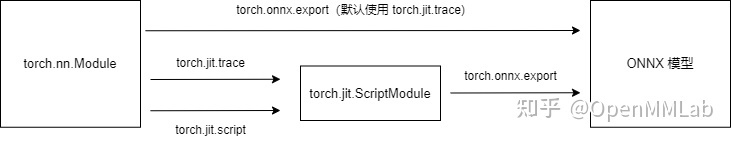

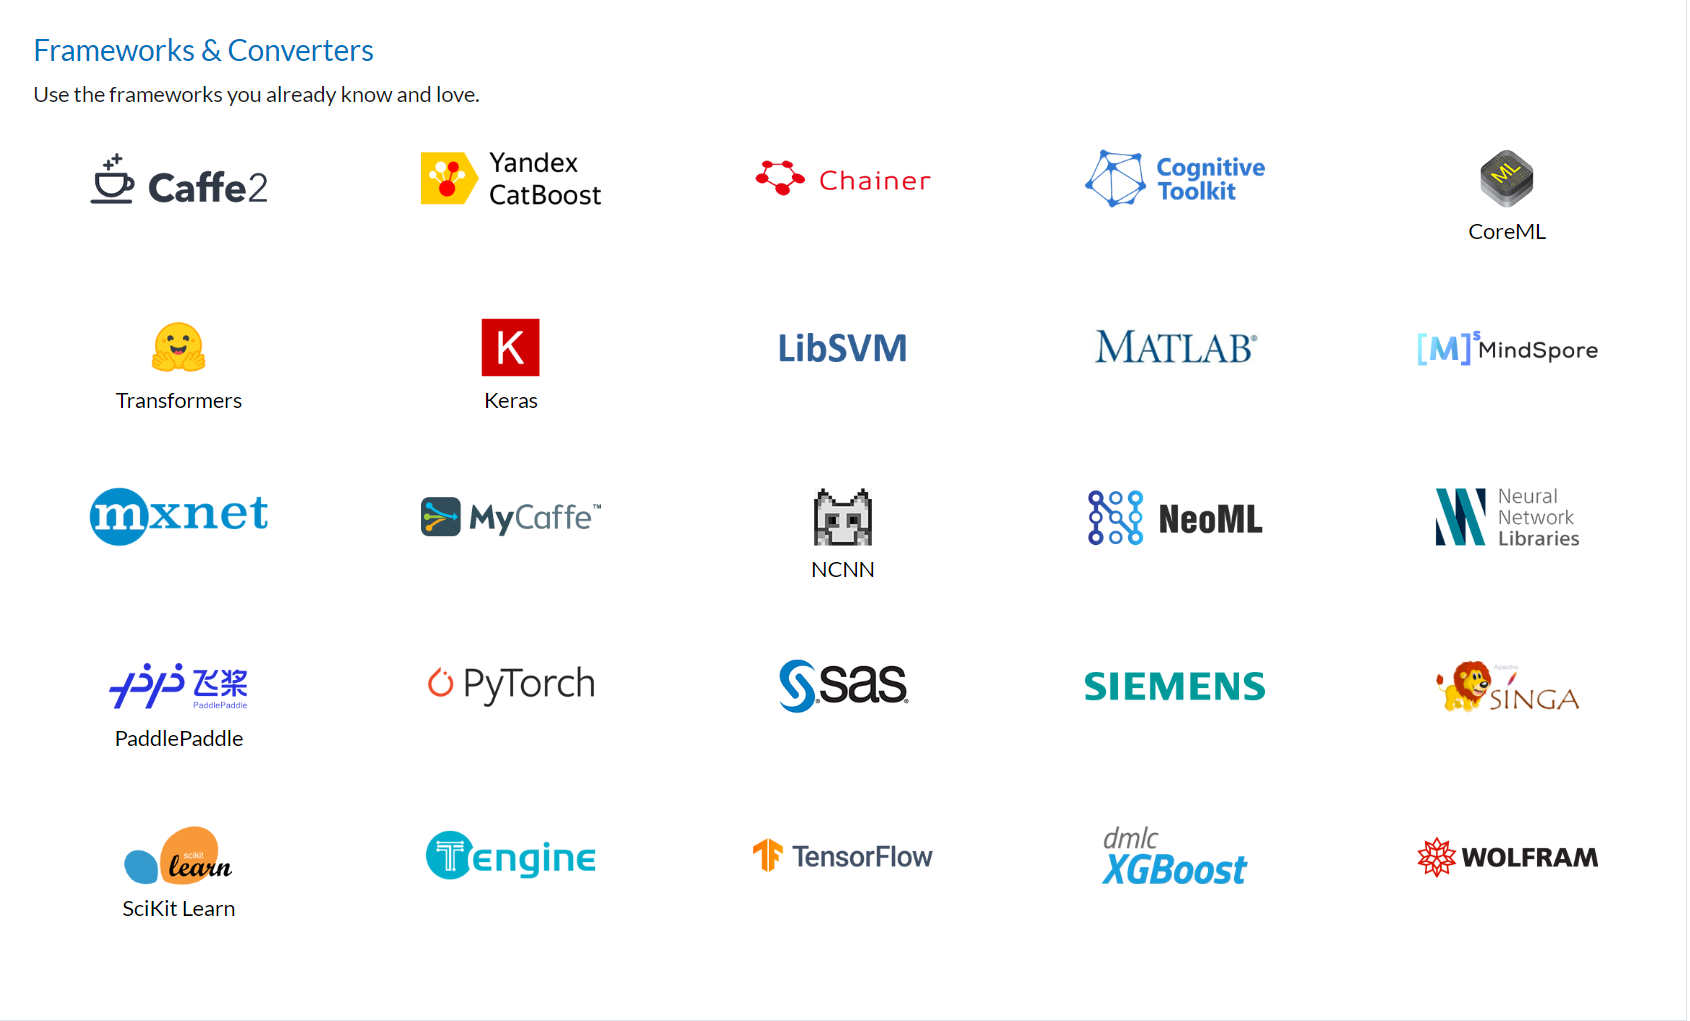



### 2、ONNX Runtime

- ONNX Runtime官网：https://www.onnxruntime.ai/
- ONNX Runtime GitHub：https://github.com/microsoft/onnxruntime

ONNX Runtime 是由微软维护的一个跨平台机器学习推理加速器，它直接对接ONNX，可以直接读取.onnx文件并实现推理，不需要再把 .onnx 格式的文件转换成其他格式的文件

PyTorch借助ONNX Runtime也完成了部署的最后一公里，构建了 PyTorch --> ONNX --> ONNX Runtime 部署流水线


#### 安装onnx
pip install onnx 
##### 安装onnx runtime
pip install onnxruntime # 使用CPU进行推理

pip install onnxruntime-gpu # 使用GPU进行推理

注意：ONNX和ONNX Runtime之间的适配关系。我们可以访问ONNX Runtime的Github进行查看

网址：https://github.com/microsoft/onnxruntime/blob/master/docs/Versioning.md

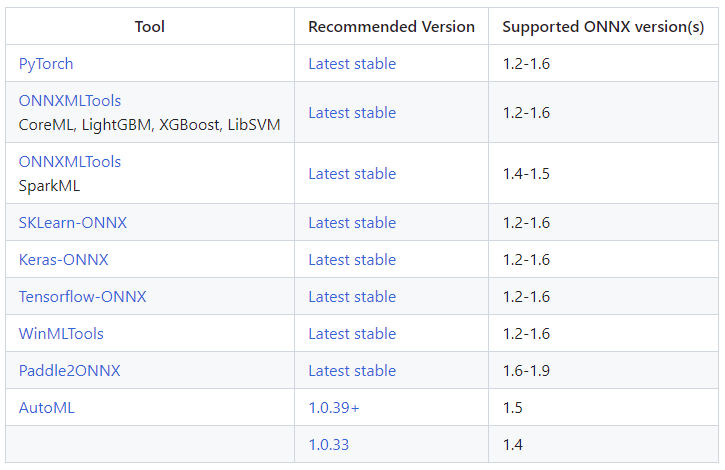

ONNX Runtime和CUDA之间的适配关系

网址：https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html

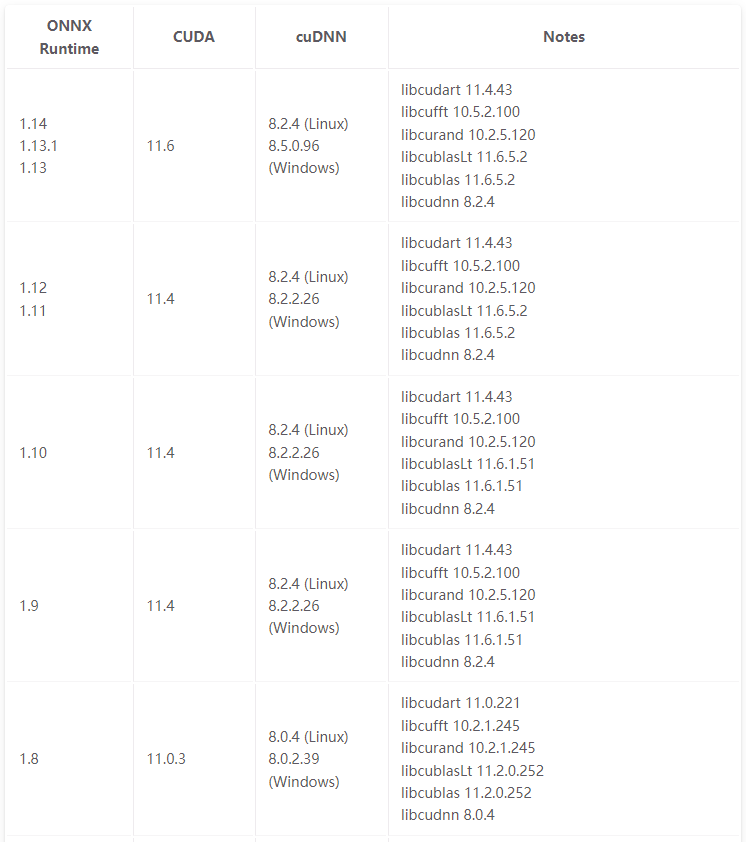

ONNX Runtime、TensorRT和CUDA的匹配关系：

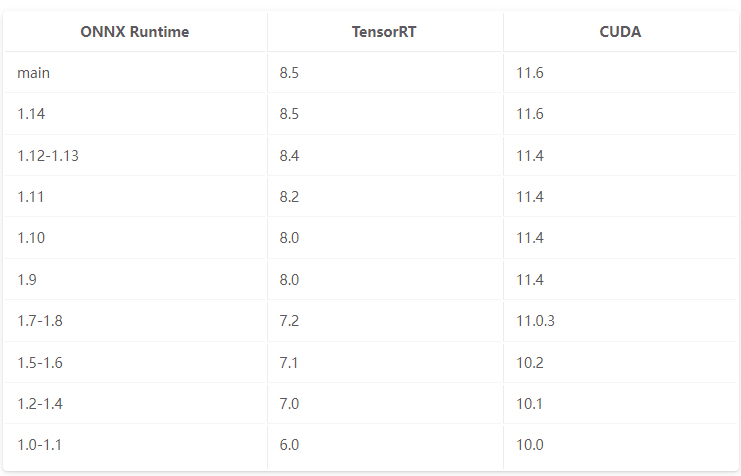

### 3、模型转换为ONNX格式

- 用torch.onnx.export()把模型转换成 ONNX 格式的函数
- 模型导成onnx格式前，我们必须调用model.eval()或者model.train(False)以确保我们的模型处在推理模式下


```python
import torch.onnx 
# 转换的onnx格式的名称，文件后缀需为.onnx
onnx_file_name = "resnet50.onnx"
# 我们需要转换的模型，将torch_model设置为自己的模型
model = torchvision.models.resnet50(pretrained=True)
# 加载权重，将model.pth转换为自己的模型权重
model = model.load_state_dict(torch.load("resnet50.pt"))
# 导出模型前，必须调用model.eval()或者model.train(False)
model.eval()
# dummy_input就是一个输入的实例，仅提供输入shape、type等信息 
batch_size = 1 # 随机的取值，当设置dynamic_axes后影响不大
dummy_input = torch.randn(batch_size, 3, 224, 224, requires_grad=True) 
# 这组输入对应的模型输出
output = model(dummy_input)
# 导出模型
torch.onnx.export(model,        # 模型的名称
                  dummy_input,   # 一组实例化输入
                  onnx_file_name,   # 文件保存路径/名称
                  export_params=True,        #  如果指定为True或默认, 参数也会被导出. 如果你要导出一个没训练过的就设为 False.
                  opset_version=10,          # ONNX 算子集的版本，当前已更新到15
                  do_constant_folding=True,  # 是否执行常量折叠优化
                  input_names = ['conv1'],   # 输入模型的张量的名称
                  output_names = ['fc'], # 输出模型的张量的名称
                  # dynamic_axes将batch_size的维度指定为动态，
                  # 后续进行推理的数据可以与导出的dummy_input的batch_size不同
                  dynamic_axes={'conv1' : {0 : 'batch_size'},    
                            'fc' : {0 : 'batch_size'}})
```

注：
算子版本对照文档：https://github.com/onnx/onnx/blob/main/docs/Operators.md

### ONNX模型的检验

我们需要检测下我们的模型文件是否可用，我们将通过onnx.checker.check_model()进行检验



```python
import onnx
# 我们可以使用异常处理的方法进行检验
try:
    # 当我们的模型不可用时，将会报出异常
    onnx.checker.check_model(self.onnx_model)
except onnx.checker.ValidationError as e:
    print("The model is invalid: %s"%e)
else:
    # 模型可用时，将不会报出异常，并会输出“The model is valid!”
    print("The model is valid!")
```

### ONNX模型可视化
使用netron做可视化。下载地址：https://netron.app/

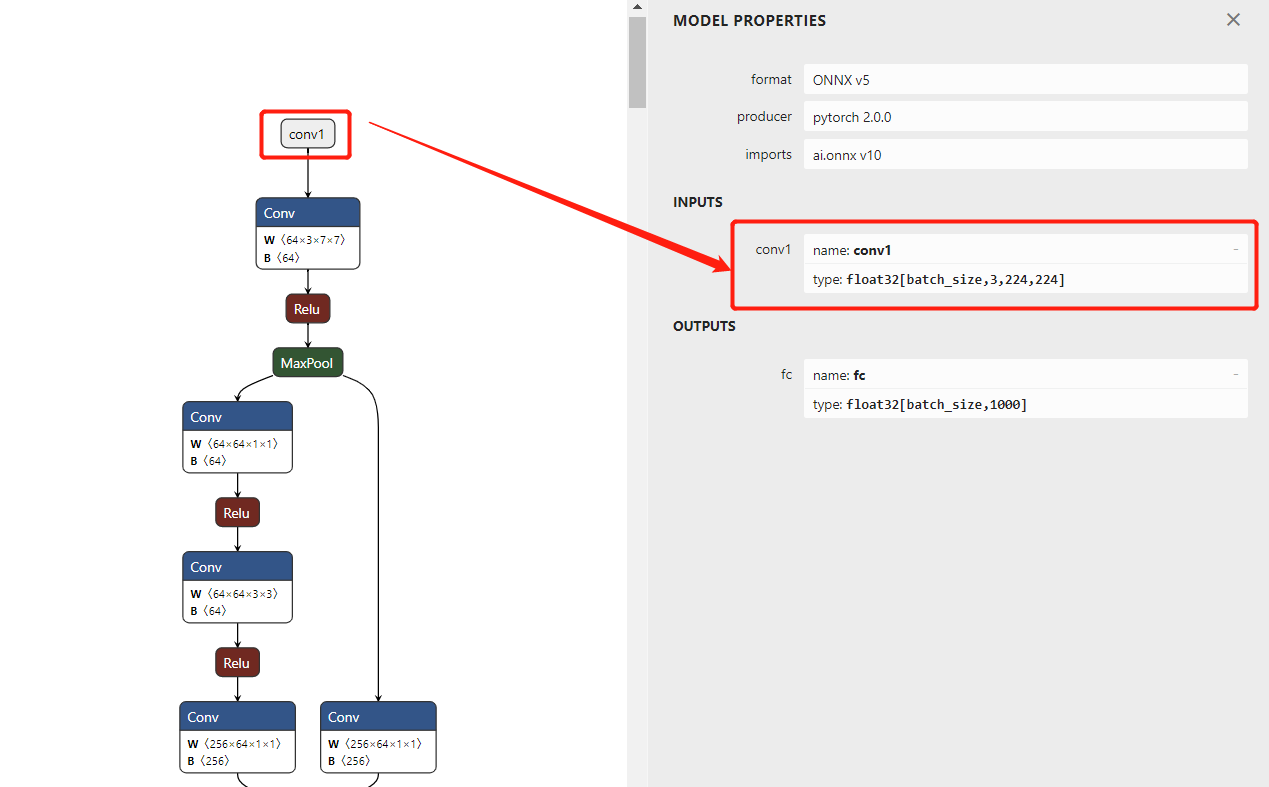


模型的输入&输出信息：

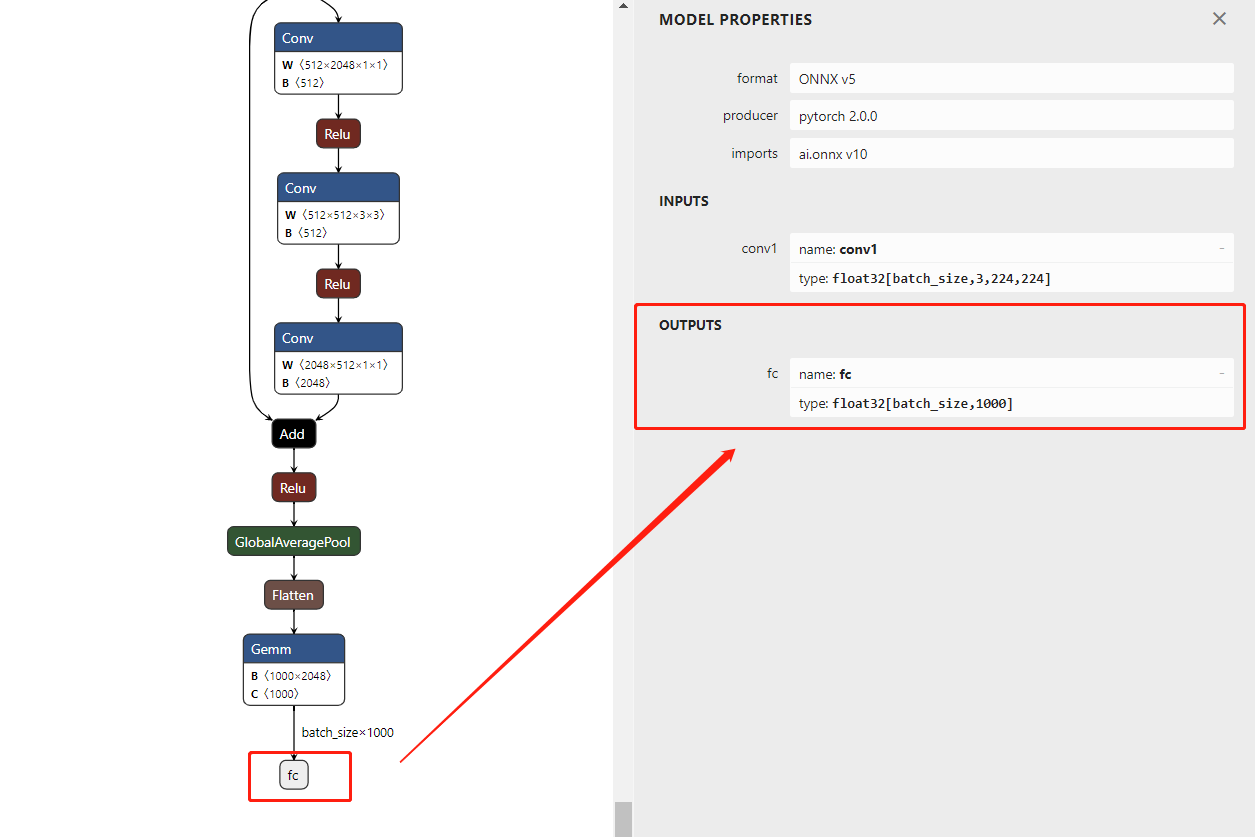


## 使用ONNX Runtime进行推理


```python

import onnxruntime
# 需要进行推理的onnx模型文件名称
onnx_file_name = "xxxxxx.onnx"

# onnxruntime.InferenceSession用于获取一个 ONNX Runtime 推理器
ort_session = onnxruntime.InferenceSession(onnx_file_name, providers=['CPUExecutionProvider'])
# session_fp32 = onnxruntime.InferenceSession("resnet50.onnx", providers=['CUDAExecutionProvider'])
# session_fp32 = onnxruntime.InferenceSession("resnet50.onnx", providers=['OpenVINOExecutionProvider'])


# 构建字典的输入数据，字典的key需要与我们构建onnx模型时的input_names相同
# 输入的input_img 也需要改变为ndarray格式
# ort_inputs = {'conv_1': input_img} 
#建议使用下面这种方法,因为避免了手动输入key
ort_inputs = {ort_session.get_inputs()[0].name:input_img}

# run是进行模型的推理，第一个参数为输出张量名的列表，一般情况可以设置为None
# 第二个参数为构建的输入值的字典
# 由于返回的结果被列表嵌套，因此我们需要进行[0]的索引
ort_output = ort_session.run(None,ort_inputs)[0]
# output = {ort_session.get_outputs()[0].name}
# ort_output = ort_session.run([output], ort_inputs)[0]

```

注意：
- PyTorch模型的输入为tensor，而ONNX的输入为array，因此我们需要对张量进行变换或者直接将数据读取为array格式
- 输入的array的shape应该和我们导出模型的dummy_input的shape相同，如果图片大小不一样，我们应该先进行resize操作
- run的结果是一个列表，我们需要进行索引操作才能获得array格式的结果
- 在构建输入的字典时，我们需要注意字典的key应与导出ONNX格式设置的input_name相同

## 完整代码

### 1. 安装&下载

In [1]:
#!pip install onnx -i https://pypi.tuna.tsinghua.edu.cn/simple
#!pip install onnxruntime -i https://pypi.tuna.tsinghua.edu.cn/simple
#!pip install torch -i https://pypi.tuna.tsinghua.edu.cn/simple
# Download ImageNet labels
#!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

### 2、定义模型

In [24]:
import torch
import io
import time
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets
import onnx
import onnxruntime
import torchvision
import numpy as np
from torch import nn
import torch.nn.init as init

In [2]:
onnx_file = 'resnet50.onnx'
save_dir = './resnet50.pt'

In [3]:

# 下载预训练模型
Resnet50 = torchvision.models.resnet50(pretrained=True)

# 保存 模型权重
torch.save(Resnet50.state_dict(), save_dir)

print(Resnet50)

D:\Users\xulele\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Users\xulele\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 3. 模型导出为ONNX格式

In [4]:

batch_size = 1    # just a random number
# 先加载模型结构
loaded_model = torchvision.models.resnet50()   
# 在加载模型权重
loaded_model.load_state_dict(torch.load(save_dir))
#单卡GPU
# loaded_model.cuda()

# 将模型设置为推理模式
loaded_model.eval()
# Input to the model
x = torch.randn(batch_size, 3, 224, 224, requires_grad=True)
torch_out = loaded_model(x)
torch_out

tensor([[-5.8050e-01,  7.5065e-02,  1.9404e-01, -9.1107e-01,  9.9716e-01,
         -1.2941e+00, -1.3402e-01, -6.4496e-01,  6.0434e-01, -1.6355e+00,
         -1.5187e-01,  1.0285e+00, -9.0719e-02, -2.6877e-01, -1.2656e+00,
         -7.9748e-01, -1.3802e+00, -9.6179e-01,  5.3512e-01,  8.3388e-02,
         -6.2868e-01,  1.5385e-01, -2.5405e-01,  4.3549e-01, -3.2834e-02,
         -8.9873e-01, -1.7059e+00, -8.5661e-01, -1.4386e+00, -2.0589e+00,
         -2.3464e+00, -3.6227e-01, -3.5712e+00, -1.6644e+00, -3.0064e-01,
         -1.8671e+00,  7.5745e-01, -2.3606e+00,  1.2460e-01,  2.7504e-01,
         -2.1071e-01, -2.6051e+00,  4.9932e-02, -3.0857e-01, -1.5757e-02,
          5.6365e-02,  1.0149e-01, -2.4776e+00,  1.7863e+00, -2.1650e+00,
          1.8615e+00, -2.8109e+00, -2.0084e+00, -5.4413e-01,  8.8444e-01,
         -8.8331e-01,  7.3980e-02, -2.0061e+00,  5.5653e-01,  7.1335e-01,
          4.6456e-01,  1.0112e+00,  4.2683e-01, -1.8685e-01, -1.1910e+00,
          1.6901e-01, -7.3501e-01, -2.

In [25]:
torch_out.size()

torch.Size([1, 1000])

In [5]:

# 导出模型
torch.onnx.export(loaded_model,               # model being run
                  x,             # model input (or a tuple for multiple inputs)
                  onnx_file,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,   # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['conv1'],   # the model's input names
                  output_names = ['fc'], # the model's output names
                  # variable length axes
                  dynamic_axes={'conv1' : {0 : 'batch_size'},    
                                'fc' : {0 : 'batch_size'}})

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### 4、检验ONNX模型

In [6]:
# 我们可以使用异常处理的方法进行检验
try:
    # 当我们的模型不可用时，将会报出异常
    onnx.checker.check_model(onnx_file)
except onnx.checker.ValidationError as e:
    print("The model is invalid: %s"%e)
else:
    # 模型可用时，将不会报出异常，并会输出“The model is valid!”
    print("The model is valid!")

The model is valid!


### 5. 使用ONNX Runtime进行推理

In [8]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession(onnx_file, providers=['CPUExecutionProvider'])

# 将张量转化为ndarray格式
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# 构建输入的字典和计算输出结果
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# 比较使用PyTorch和ONNX Runtime得出的精度
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


### 6. 进行实际预测并可视化

In [9]:
# 推理数据
from PIL import Image
from torchvision.transforms import transforms

# 生成推理图片
image = Image.open('./images/cat.jpg')

# 将图像调整为指定大小
image = image.resize((224, 224))

# 将图像转换为 RGB 模式
image = image.convert('RGB')

image.save('./images/cat_224.jpg')


In [15]:
categories = []
# Read the categories
with open("./imagenet/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    
def get_class_name(probabilities):
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())
    


In [16]:
#预处理
def pre_image(image_file):
    input_image = Image.open(image_file)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    inputs = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # input_arr = inputs.cpu().detach().numpy()
    return inputs 

In [23]:
#inference with model

# 先加载模型结构
resnet50 = torchvision.models.resnet50()   
# 在加载模型权重
resnet50.load_state_dict(torch.load(save_dir))

resnet50.eval()  
#推理
input_batch = pre_image('./images/cat_224.jpg')

# move the input and model to GPU for speed if available
print("GPU Availability: ", torch.cuda.is_available())
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    resnet50.to('cuda')
    
with torch.no_grad():
    output = resnet50(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
get_class_name(probabilities)

GPU Availability:  False
Persian cat 0.6668420433998108
lynx 0.023987364023923874
bow tie 0.016234245151281357
hair slide 0.013150070793926716
Japanese spaniel 0.012279157526791096


In [32]:
input_batch.size()

torch.Size([1, 3, 224, 224])

In [18]:
#benchmark 性能
latency = []
for i in range(10):
    with torch.no_grad():
        start = time.time()
        output = resnet50(input_batch)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        top5_prob, top5_catid = torch.topk(probabilities, 5)
        # for catid in range(top5_catid.size(0)):
        #     print(categories[catid])
        latency.append(time.time() - start)
    print("{} model inference CPU time:cost {} ms".format(str(i),format(sum(latency) * 1000 / len(latency), '.2f')))

0 model inference CPU time:cost 149.59 ms
1 model inference CPU time:cost 130.74 ms
2 model inference CPU time:cost 133.76 ms
3 model inference CPU time:cost 130.64 ms
4 model inference CPU time:cost 131.72 ms
5 model inference CPU time:cost 130.88 ms
6 model inference CPU time:cost 136.31 ms
7 model inference CPU time:cost 139.95 ms
8 model inference CPU time:cost 141.90 ms
9 model inference CPU time:cost 140.96 ms


In [19]:
# Inference with ONNX Runtime
import onnxruntime
from onnx import numpy_helper
import time
onnx_file = 'resnet50.onnx'
session_fp32 = onnxruntime.InferenceSession(onnx_file, providers=['CPUExecutionProvider'])
# session_fp32 = onnxruntime.InferenceSession("resnet50.onnx", providers=['CUDAExecutionProvider'])
# session_fp32 = onnxruntime.InferenceSession("resnet50.onnx", providers=['OpenVINOExecutionProvider'])

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


latency = []
def run_sample(session, categories, inputs):
    start = time.time()
    input_arr = inputs
    ort_outputs = session.run([], {'conv1':input_arr})[0]
    output = ort_outputs.flatten()
    output = softmax(output) # this is optional
    top5_catid = np.argsort(-output)[:5]
    # for catid in top5_catid:
    #     print(categories[catid])
    latency.append(time.time() - start)
    return ort_outputs


In [20]:

input_tensor = pre_image('./images/cat_224.jpg')
input_arr = input_tensor.cpu().detach().numpy()
for i in range(10):
    ort_output = run_sample(session_fp32, categories, input_arr)
    print("{} ONNX Runtime CPU Inference time = {} ms".format(str(i),format(sum(latency) * 1000 / len(latency), '.2f')))

0 ONNX Runtime CPU Inference time = 67.66 ms
1 ONNX Runtime CPU Inference time = 56.30 ms
2 ONNX Runtime CPU Inference time = 53.90 ms
3 ONNX Runtime CPU Inference time = 58.18 ms
4 ONNX Runtime CPU Inference time = 64.53 ms
5 ONNX Runtime CPU Inference time = 62.79 ms
6 ONNX Runtime CPU Inference time = 61.75 ms
7 ONNX Runtime CPU Inference time = 60.51 ms
8 ONNX Runtime CPU Inference time = 59.35 ms
9 ONNX Runtime CPU Inference time = 57.57 ms


## 4、扩展知识
- 模型量化
- 模型剪裁
- 工程优化
- 算子优化